In [13]:
!pip3 install torchsummary
import os
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from torchsummary import summary
from transformers import ViTModel
from PIL import Image
import requests
from datetime import datetime
import math
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [2]:
base_dir = '/kaggle/input/fruits/fruits-360_dataset/fruits-360'
train_dir = os.path.join(base_dir, 'Training')
test_dir = os.path.join(base_dir, 'Test')

### Preparing the dataset
Set up device and training hyperparameters for the model. 

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

epochs = 1
batch_size = 512
image_height = 224
image_width = 224
num_channels = 3
latent_dim = 256
learning_rate = 0.001

cuda


The ViT transformer model pre-trained on ImageNet-21k (14 million images, 21,843 classes) at resolution 224x224. Therefore, we change the image dimensions from 100x100 to 224x224. We calcuate the mean and standard deviation of color channels to normalize the dataset.

In [21]:
transforms_data = transforms.Compose([ transforms.Resize((image_height, image_width)),
                                        transforms.ToTensor()])
train_dataset = ImageFolder(train_dir, transform=transforms_data)
test_dataset = ImageFolder(test_dir, transform=transforms_data)
num_classes = len(train_dataset.classes)

dataloader_train = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, pin_memory=True)
dataloader_test = DataLoader(test_dataset, batch_size=batch_size * 2, shuffle=False, pin_memory=True)

#Calculating mean and std
batch_size = 512

loader = DataLoader(
  train_dataset, 
  batch_size = batch_size, 
  num_workers=1)

def batch_mean_and_sd(loader):
    
    cnt = 0
    fst_moment = torch.empty(3)
    snd_moment = torch.empty(3)

    for images, _ in loader:
        b, c, h, w = images.shape
        nb_pixels = b * h * w
        sum_ = torch.sum(images, dim=[0, 2, 3])
        sum_of_square = torch.sum(images ** 2,
                                  dim=[0, 2, 3])
        fst_moment = (cnt * fst_moment + sum_) / (
                      cnt + nb_pixels)
        snd_moment = (cnt * snd_moment + sum_of_square) / (
                            cnt + nb_pixels)
        cnt += nb_pixels

    mean, std = fst_moment, torch.sqrt(
      snd_moment - fst_moment ** 2)        
    return mean,std
  
mean, std = batch_mean_and_sd(loader)
print("mean and std: \n", mean, std)

mean and std: 
 tensor([0.6840, 0.5786, 0.5037]) tensor([0.3015, 0.3581, 0.3895])


In [4]:
transforms_data = transforms.Compose([transforms.Resize((image_height, image_width)),
                                    transforms.ToTensor(),
                                     transforms.Normalize([0.6840, 0.5786, 0.5037], [0.3015, 0.3581, 0.3895])])

train_dataset = ImageFolder(train_dir, transform=transforms_data)
test_dataset = ImageFolder(test_dir, transform=transforms_data)
num_classes = len(train_dataset.classes)

train_generator = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, pin_memory=True)
test_generator = DataLoader(test_dataset, batch_size=batch_size * 2, shuffle=False, pin_memory=True)

print('Train Dataset Size: ', len(train_dataset))
print('Test Dataset Size: ', len(test_dataset))

Train Dataset Size:  67692
Test Dataset Size:  22688


### ViT transformer
We import the pretrained model and freeze the layers in ViT freeze the layers to extract more generic features of the classes.

In [5]:
vit = ViTModel.from_pretrained('google/vit-base-patch16-224-in21k')
for param in vit.parameters():
    param.requires_grad = False

vit.pooler.dense.weight.requires_grad = True
vit.pooler.dense.bias.requires_grad = True

Downloading:   0%|          | 0.00/502 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/330M [00:00<?, ?B/s]

We created a classier model based on the pre-trained ViT transformer.

In [6]:
class CategoryClass(nn.Module):
    def __init__(self, vit, latent_dim, classes_):
        super(CategoryClass, self).__init__()
        self.classes_ = classes_
        self.vit = vit
        self.fc_1 = nn.Linear(768, latent_dim)
        self.fc_out = nn.Linear(latent_dim, self.classes_)
        self.dropout = nn.Dropout(0.2)
        
    def forward(self, in_data):
        
        vit_outputs = self.vit(in_data)
        pooler_output = vit_outputs.pooler_output
        outputs = torch.relu(self.fc_1(pooler_output))
        outputs = self.fc_out(self.dropout(outputs))
        return outputs

In [7]:
model = CategoryClass(vit,
                      latent_dim,
                      len(train_dataset.classes)).to(device)
#We use cross entropy loss and Adam optimizer as hyperparameters.
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), learning_rate)

#### Training the model

In [9]:
# Save the training and validating accuracy and loss
training_loss_history =[]
training_accuracy_history = []
validating_loss_history = []
validating_accuracy_history = []
#Save the batch accuracy
batch_loss_history = []
batch_accuracy_history = []

print('Start Training')
print('*'*100)
start_time = datetime.now()
for epoch in range(epochs):
    model.train()
    train_epoch_loss = 0.0
    train_epoch_accuracy = 0.0
    for idx, (images, labels) in enumerate(train_generator):
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        
        #collect the loss function
        loss = criterion(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # collect the accuracy
        train_epoch_loss += loss.item()
        predict_class = outputs.argmax(dim=-1)
        accuracy = torch.sum(predict_class == labels).item() / labels.shape[0]
        train_epoch_accuracy += accuracy

        batch_loss_history.append(loss.item())
        batch_accuracy_history.append(accuracy)
    
    model.eval()
    val_epoch_loss = 0.0
    val_epoch_accuracy = 0.0
    
    with torch.no_grad():
        for val_images, val_labels in test_generator:
            # Move data to the device
            val_images = val_images.to(device)
            val_labels = val_labels.to(device)
            
            # Pass through model
            val_outputs = model(val_images)
            
            # Count the loss and accuracy
            val_epoch_loss += criterion(val_outputs, val_labels)
            val_predict_class = val_outputs.argmax(dim=-1)
            val_epoch_accuracy += torch.sum(val_predict_class == val_labels).item() / val_labels.shape[0]
            
    # Save the epoch information
    training_loss_history.append(100*train_epoch_loss / len(train_generator))
    training_accuracy_history.append(100*train_epoch_accuracy / len(train_generator))
    validating_loss_history.append(100*val_epoch_loss / len(test_generator))
    validating_accuracy_history.append(100*val_epoch_accuracy / len(test_generator))
    
    print('Epoch {}/{}, Training Loss: {:.3f}, Training Accuracy: {:.3f}, Testing Loss: {:.3f}, Testing Acc: {:.3f}'
          .format(epoch + 1, epochs, training_loss_history[-1], training_accuracy_history[-1], validating_loss_history[-1], validating_accuracy_history[-1]))

    end_time = datetime.now()
    epoch_time = (end_time - start_time).total_seconds()
    print("-"*100)
    print('Epoch Time : ', math.floor(epoch_time // 60), ':', math.floor(epoch_time % 60))
    print("-"*100)
    
print("*** Training Completed ***")

Start Training
****************************************************************************************************
Epoch 1/1, Training Loss: 91.651, Training Accuracy: 82.613, Testing Loss: 13.032, Testing Acc: 96.518
----------------------------------------------------------------------------------------------------
Epoch Time :  30 : 2
----------------------------------------------------------------------------------------------------
*** Training Completed ***


In [10]:
# Save the model weight
torch.save(model.state_dict(), "ViTmodel.pt")

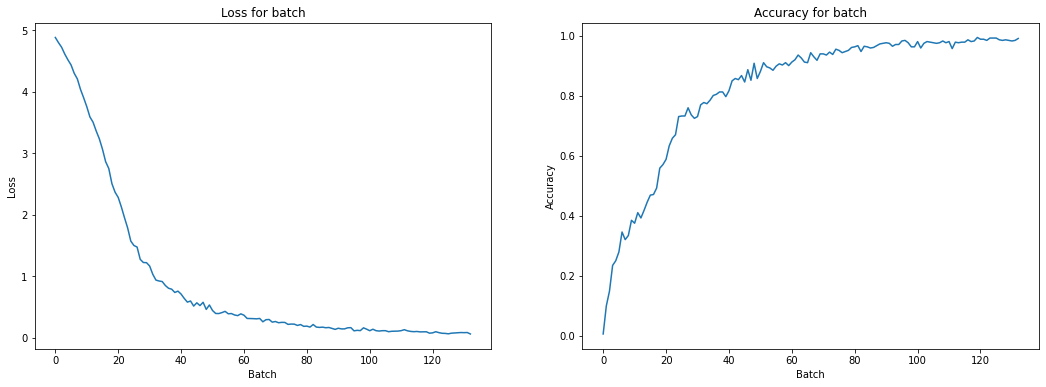

In [11]:
# Plot the loss and accuracy
plt.figure(figsize=(18,6))

# Loss
plt.subplot(1, 2, 1)
plt.title("Loss for batch")
plt.xlabel("Batch")
plt.ylabel("Loss")
plt.plot(batch_loss_history)

# Accuracy
plt.subplot(1, 2, 2)
plt.title("Accuracy for batch")
plt.xlabel("Batch")
plt.ylabel("Accuracy")
plt.plot(batch_accuracy_history)